## Make Rain Plot for Poster

* this code pulls in pickle data from the hovmoller generation code and creates a plot of rainfall for a site,
* then makes a plot of rainfall data with the wet and dry seasons used to generate the geomedian composites highlighted
* rainfall data is currently in WGS84 due to datacube issues. This isn't a problem at the moment but could be later.

Dependencies:

  * pickled rainfall data for the site
  * the location of the data

Bex Dunn June 2017

In [1]:
#in this notebook we want to plot non-interactively
%matplotlib inline

#get a bunch of modules to use
import xarray as xr
import datetime as dt
import matplotlib as mpl
from matplotlib import colors
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import matplotlib.gridspec as gridspec
import numpy as np
import pickle
import os

### get the data to plot from a previously created pickle-file

In [2]:

#name the file location:
openpath = '/g/data/r78/rjd547/groundwater_activities/GalileeBasin/pickledata/v2Carmichael_River_transect_ix8/'

In [3]:
#Define temporal range - testing with one year of data
start_of_epoch = '1987-10-01'
#need a variable here that defines a rolling 'latest observation'  
end_of_epoch =  '2016-10-01'
print ('temporal range is '+start_of_epoch+' to '+end_of_epoch)

temporal range is 1987-10-01 to 2016-10-01


In [4]:
# #resample xarray Dataset Studysite_rain by Annual'AS' to get yearly avg with year starting in october
# #Note that the resampling we did means that each year is labelled according to its first day  
# rain_sp = Studysite_rain.mean(dim = ('latitude','longitude'))
# month_sp = rain_sp.resample('MS', dim = 'time', how = 'mean')
# year_avg = Studysite_rain.resample('AS-OCT', dim='time', how='mean', keep_attrs=True)
# # Create a spatial average
# year_avg_sp = year_avg.mean(dim = ('latitude', 'longitude'))

In [8]:
os.chdir(openpath)

In [9]:
os.listdir(openpath)

['Rainfall_data.pkl',
 'v2Carmichael_River_transect_ix8transect_img.png',
 'Hov_plot_tcw_variables.pkl',
 'v2Carmichael_River_transect_ix8HovPlot_TCW.png',
 'NBARPQ_data.pkl',
 'v2Carmichael_River_transect_ix8HovPlot.png',
 'Hov_plot_variables.pkl']

In [13]:
#open our saved data
saved_vars = pd.read_pickle('Hov_plot_variables.pkl')
#print(saved_vars.keys())
rain_sp = saved_vars['rain_sp']
month_sp = saved_vars['month_sp']
f.close()
#get rid of the data we don't want from memory
del saved_vars

ModuleNotFoundError: No module named 'pandas.indexes'

In [ ]:
#did not save year_avg_sp so recreate it:
year_avg_sp = rain_sp.resample('AS-OCT', dim='time', how='mean', keep_attrs=True)
year_avg_sp

In [ ]:
#Make a plot of the years we have chosen
year_avg_sp.rainfall.plot(color = 'b')
#here we index the dataset to plot the selected wet and dry years on top
wet1 = year_avg_sp.where(year_avg_sp.rainfall>=threshold95).rainfall.plot(color ='c', marker ='o')
dry1 = year_avg_sp.where(year_avg_sp.rainfall<=threshold5).rainfall.plot(color = 'r', marker = 'o')
#FIXME fix the x ticks at some point
#plt.xticks(np.arange(1))
#print(ticker.get_xlim())
plt.title('Selected wet and dry periods of rainfall for site ')#+str(Studysite[0]))
plt.show()

In [ ]:
rain_sp.isel(time=-1)

In [8]:
# Find the 95th percentile in rainfall
threshold95 = year_avg_sp.reduce(np.percentile, dim = 'time', q = 95)
# Find the 5th percentile in rainfall (least)
threshold5 = year_avg_sp.reduce(np.percentile, dim = 'time', q = 5)
print('5th  q: ',threshold5.rainfall.values,'\n'+'95th q: ',threshold95.rainfall.values )

#work out which of the years have rainfall less than
wet_yrs = year_avg_sp.where(year_avg_sp.rainfall>=threshold95).dropna(dim = 'time')
dry_yrs = year_avg_sp.where(year_avg_sp.rainfall<=threshold5).dropna(dim = 'time')

#turn into numpy datetimes for later timeslicing
wet_dt=np.array(wet_yrs.time.values,dtype = 'datetime64[M]')
dry_dt=np.array(dry_yrs.time.values,dtype = 'datetime64[M]')

#print out our wet and dry years
print('wet years begin: ', wet_dt)
print('dry years begin: ', dry_dt)

#Dry seasons of wet and dry years are set up as july -october (e.g. 7-10)
#hydrological year starts october of the year before, so interval on graph needs to be july-october of following year
wetslice_start = np.array(wet_dt+9,dtype = 'datetime64[M]')
dryslice_start = np.array(dry_dt+9,dtype = 'datetime64[M]')

wetslice_end = np.array(wet_dt+12,dtype = 'datetime64[M]')
dryslice_end = np.array(dry_dt+12,dtype = 'datetime64[M]')

#choose a wet and dry?
wet_slice1 = month_sp.rainfall.sel(time=slice(wetslice_start[1], wetslice_end[1])) #this one
dry_slice1 = month_sp.rainfall.sel(time=slice(dryslice_start[1], dryslice_end[1]))
wet_slice0 = month_sp.rainfall.sel(time=slice(wetslice_start[0], wetslice_end[0]))
dry_slice0 = month_sp.rainfall.sel(time=slice(dryslice_start[0], dryslice_end[0])) #and this one

# print(wet_slice0.sum(), wet_slice0.time)
# print(wet_slice1.sum(), wet_slice1.time)
# print(dry_slice0.sum(),dry_slice0.time)
# print(dry_slice1.sum(), dry_slice1.time)

5th  q:  0.7836657345294953 
95th q:  2.2085619926452638
wet years begin:  ['2009-10' '2011-10']
dry years begin:  ['1991-10' '2012-10']


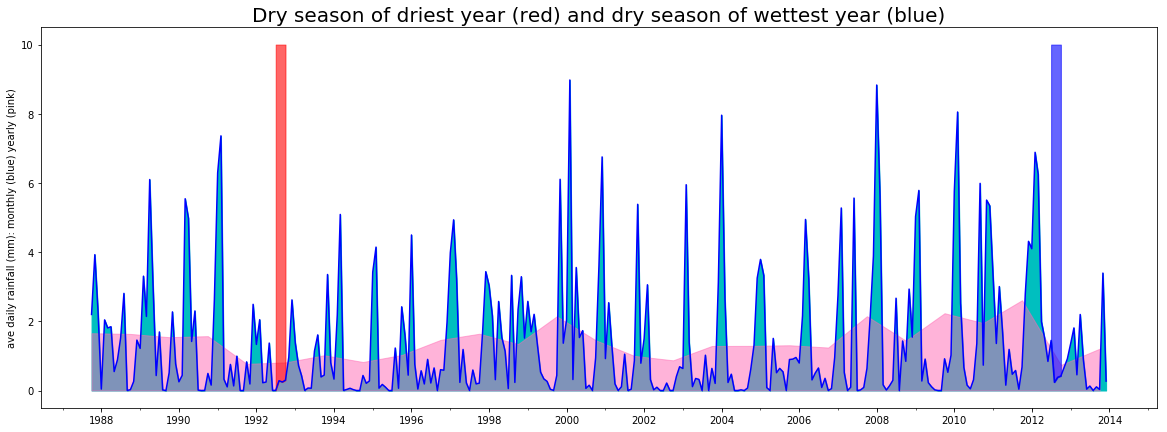

In [9]:
# #Make a hovmoller plot and save it to file.
# #Use firstyear and last year to zoom into periods of interest
# firstyearhov = start_of_epoch#'1987-06-01'
# lastyearhov = end_of_epoch #'2016-12-31'

# fig, axes = plt.subplots(figsize=(20,7))
# axes.plot(month_sp.time, month_sp.rainfall, color='b', alpha = 1)
# axes.set_ylabel('ave daily rainfall (mm): monthly (blue) yearly (pink)')

# # #set up fill time as a datetime 64 object for matplotlib input
# # #set up variables to plot the fill behind the yearly rain data
# filltime = (year_avg_sp.time.astype('datetime64'))
# zeros = np.zeros(shape=(len(filltime)))

# #fakevals is a set of fake maximum values in the size of our dry time slice.
# fake_maxvals=(np.zeros(shape=(len(dry_slice0))))+10 #have set to 10, but to set to max month_sp.rainfall.max().data

# mzeros = np.zeros(shape=(len(month_sp.rainfall.time.values)))
# years =mdates.YearLocator(base=2)
# minor_years=mdates.YearLocator()

# axes.fill_between(month_sp.rainfall.time.values, mzeros, month_sp.rainfall, color ='c', alpha = 1)
# axes.fill_between(filltime.time.values, year_avg_sp.rainfall, color ='hotpink', alpha = 0.5)

# axes.fill_between(dry_slice0.time.values, fake_maxvals, dry_slice0, color ='r', alpha = 0.6)
# axes.fill_between(wet_slice1.time.values, fake_maxvals, wet_slice1, color ='b', alpha = 0.6)

# axes.xaxis.set_major_locator(years)
# axes.xaxis.set_minor_locator(minor_years)

# plt.title('Dry season of driest year (red) and dry season of wettest year (blue)',fontsize=20)
# plt.show()

In [10]:
# fig.savefig('/g/data/r78/rjd547/groundwater_activities/Rain_for_poster2.png',)
# plt.show()


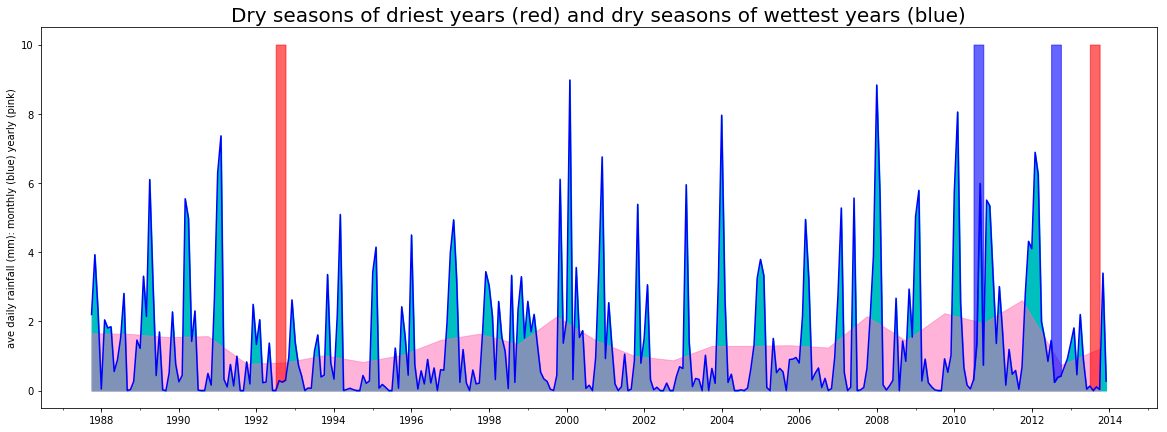

In [11]:
# #Make a hovmoller plot and save it to file.
# #Use firstyear and last year to zoom into periods of interest
# firstyearhov = start_of_epoch#'1987-06-01'
# lastyearhov = end_of_epoch #'2016-12-31'

# fig, axes = plt.subplots(figsize=(20,7))
# axes.plot(month_sp.time, month_sp.rainfall, color='b', alpha = 1)
# axes.set_ylabel('ave daily rainfall (mm): monthly (blue) yearly (pink)')

# # #set up fill time as a datetime 64 object for matplotlib input
# # #set up variables to plot the fill behind the yearly rain data
# filltime = (year_avg_sp.time.astype('datetime64'))
# zeros = np.zeros(shape=(len(filltime)))

# #fakevals is a set of fake maximum values in the size of our dry time slice.
# fake_maxvals=(np.zeros(shape=(len(dry_slice0))))+10 #have set to 10, but to set to max month_sp.rainfall.max().data

# mzeros = np.zeros(shape=(len(month_sp.rainfall.time.values)))
# years =mdates.YearLocator(base=2)
# minor_years=mdates.YearLocator()

# axes.fill_between(month_sp.rainfall.time.values, mzeros, month_sp.rainfall, color ='c', alpha = 1)
# axes.fill_between(filltime.time.values, year_avg_sp.rainfall, color ='hotpink', alpha = 0.5)

# axes.fill_between(dry_slice0.time.values, fake_maxvals, dry_slice0, color ='r', alpha = 0.6)
# axes.fill_between(dry_slice1.time.values, fake_maxvals, dry_slice1, color ='r', alpha = 0.6)
# axes.fill_between(wet_slice0.time.values, fake_maxvals, wet_slice0, color ='b', alpha = 0.6)
# axes.fill_between(wet_slice1.time.values, fake_maxvals, wet_slice1, color ='b', alpha = 0.6)

# axes.xaxis.set_major_locator(years)
# axes.xaxis.set_minor_locator(minor_years)

# plt.title('Dry seasons of driest years (red) and dry seasons of wettest years (blue)',fontsize=20)
# plt.show()

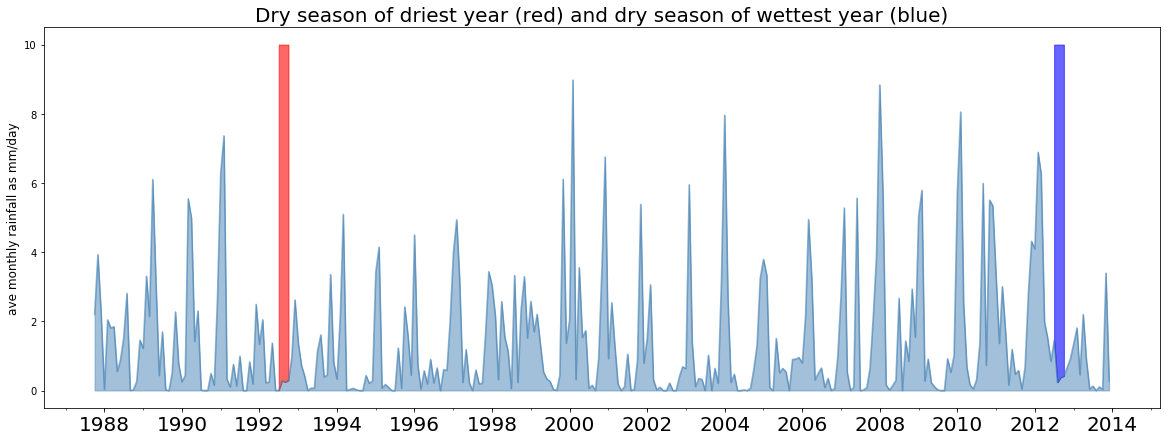

In [30]:
# #Make a hovmoller plot and save it to file.
# #Use firstyear and last year to zoom into periods of interest
# firstyearhov = start_of_epoch#'1987-06-01'
# lastyearhov = end_of_epoch #'2016-12-31'

# fig, axes = plt.subplots(figsize=(20,7))
# axes.plot(month_sp.time, month_sp.rainfall, color='steelblue', alpha = 0.6)
# axes.set_ylabel('ave monthly rainfall as mm/day', fontsize =12)

# # #set up fill time as a datetime 64 object for matplotlib input
# # #set up variables to plot the fill behind the yearly rain data
# filltime = (year_avg_sp.time.astype('datetime64'))
# zeros = np.zeros(shape=(len(filltime)))

# #fakevals is a set of fake maximum values in the size of our dry time slice.
# fake_maxvals=(np.zeros(shape=(len(dry_slice0))))+10 #have set to 10, but to set to max month_sp.rainfall.max().data

# mzeros = np.zeros(shape=(len(month_sp.rainfall.time.values)))
# years =mdates.YearLocator(base=2)
# minor_years=mdates.YearLocator()
# #change the font size on the time labels
# for tick in axes.xaxis.get_major_ticks():
#                 tick.label.set_fontsize(20)



# axes.fill_between(month_sp.rainfall.time.values,
#                   mzeros, month_sp.rainfall, color ='steelblue', alpha = 0.5)

# axes.fill_between(dry_slice0.time.values, fake_maxvals, dry_slice0, color ='r', alpha = 0.6)
# axes.fill_between(wet_slice1.time.values, fake_maxvals, wet_slice1, color ='b', alpha = 0.6)

# axes.xaxis.set_major_locator(years)
# axes.xaxis.set_minor_locator(minor_years)

# plt.title('Dry season of driest year (red) and dry season of wettest year (blue)',fontsize=20)

# plt.savefig('/g/data/r78/rjd547/groundwater_activities/Images/Rain_for_poster.png',
#            box_inches='tight', pad_inches=0)

# plt.show()

In [ ]:
#Make a hovmoller plot and save it to file.
#Use firstyear and last year to zoom into periods of interest
firstyearhov = start_of_epoch#'1987-06-01'
lastyearhov = end_of_epoch #'2016-12-31'

fig, axes = plt.subplots(figsize=(20,7))
axes.plot(month_sp.time, month_sp.rainfall, color='steelblue', alpha = 0.6)
axes.set_ylabel('ave monthly rainfall as mm/day', fontsize =12)

# #set up fill time as a datetime 64 object for matplotlib input
# #set up variables to plot the fill behind the yearly rain data
filltime = (year_avg_sp.time.astype('datetime64'))
zeros = np.zeros(shape=(len(filltime)))

#fakevals is a set of fake maximum values in the size of our dry time slice.
fake_maxvals=(np.zeros(shape=(len(dry_slice0))))+10 #have set to 10, but to set to max month_sp.rainfall.max().data

mzeros = np.zeros(shape=(len(month_sp.rainfall.time.values)))
years =mdates.YearLocator(base=2)
minor_years=mdates.YearLocator()
#change the font size on the time labels
for tick in axes.xaxis.get_major_ticks():
                tick.label.set_fontsize(20)



axes.fill_between(month_sp.rainfall.time.values,
                  mzeros, month_sp.rainfall, color ='steelblue', alpha = 0.5)

axes.fill_between(dry_slice0.time.values, fake_maxvals, dry_slice0, color ='r', alpha = 0.6)
axes.fill_between(wet_slice1.time.values, fake_maxvals, wet_slice1, color ='b', alpha = 0.6)

axes.xaxis.set_major_locator(years)
axes.xaxis.set_minor_locator(minor_years)

plt.title('Dry season of driest year (red) and dry season of wettest year (blue)',fontsize=20)

plt.savefig('/g/data/r78/rjd547/groundwater_activities/Images/Rain_for_poster.png',
           box_inches='tight', pad_inches=0)

plt.show()